# 01 - Mutual Information & SHAP, LIME  - comparison


Mutual Information
Purpose: Identify relationships between features and the target variable.
What it does: Mutual Information (MI) measures the amount of information one variable provides about another. It captures both linear and nonlinear dependencies.
Features with high MI scores are considered more important for predicting the target.

Purpose: Explain model predictions by attributing the contribution of each feature.
What it does:SHAP is based on cooperative game theory (Shapley values).
It explains the output of a machine learning model by distributing the model’s prediction across its features.

LIME (Local Interpretable Model-agnostic Explanations)
Purpose: Explain individual predictions of a machine learning model.
What it does: LIME explains the prediction for a specific instance by fitting a simple, interpretable model (like linear regression) to approximate the behavior of the complex model around that instance.

In [113]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
import shap
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pip install shap
# pip install lime


In [114]:
# Load data
df = pd.read_csv("Numeric data (last year work).csv")

# Set the target and features
X = df.drop('Rating', axis=1)  # Drop the target column
y = df['Rating']              # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [115]:
# Initial Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Print metrics in a readable format
print("Initial Metrics:")
for metric, value in metrics_initial.items():
    print(f"{metric}: {value}")


Initial Metrics:
MAE: 0.29
MSE: 0.13
RMSE: 0.36
R-squared: 0.5


Evaluation Metrics (Test Set):

MAE (Mean Absolute Error): 0.29
MSE (Mean Squared Error): 0.13 ^2
RMSE (Root Mean Squared Error): 0.37
R-squared: 0.5


C:\Users\e1003118\AppData\Local\Temp\ipykernel_3384\955271574.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - y_test_pred), kde=True, bins=30, color="blue")


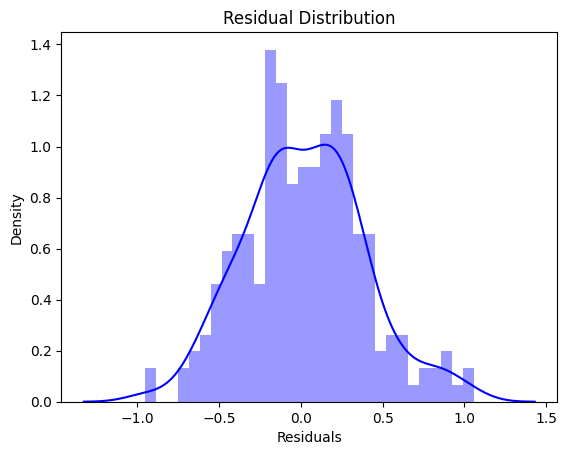

Metrics after Mutual Information: {'MAE': 0.29, 'MSE': 0.13, 'RMSE': 0.37, 'R-squared': 0.5}


In [116]:
# Mutual Information
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info_sorted_indices = np.argsort(mutual_info)[::-1]
X_train_mi = X_train.iloc[:, mutual_info_sorted_indices[:int(0.8 * len(mutual_info))]]  # Retain top 80% features
X_test_mi = X_test.iloc[:, mutual_info_sorted_indices[:int(0.8 * len(mutual_info))]]

model.fit(X_train_mi, y_train)
metrics_mi = evaluate_model(model, X_train_mi, X_test_mi, y_train, y_test)
print("Metrics after Mutual Information:", metrics_mi)

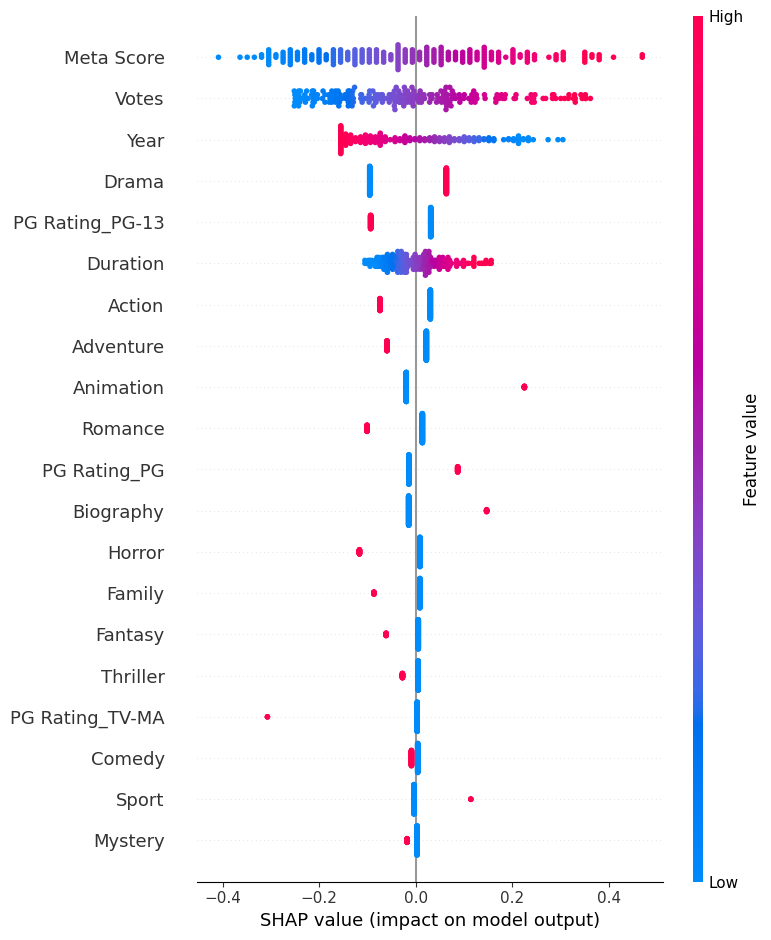

In [117]:
# SHAP
# Create a SHAP explainer
explainer = shap.LinearExplainer(model, X_train_mi)  # Use X_train_mi (Mutual Information features)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_mi)  # Use shap_values method to compute

# Plot the summary of SHAP values
shap.summary_plot(shap_values, X_test_mi)

# Select top features based on SHAP importance
mean_shap_values = np.abs(shap_values).mean(axis=0)  # Compute mean absolute SHAP values
top_shap_features = np.argsort(mean_shap_values)[::-1][:int(0.8 * X_train_mi.shape[1])]

X_train_shap = X_train_mi.iloc[:, top_shap_features]
X_test_shap = X_test_mi.iloc[:, top_shap_features]


In [118]:
from lime.lime_tabular import LimeTabularExplainer

# Create LIME explainer using the selected features
lime_explainer = LimeTabularExplainer(
    X_train_mi.values,  # Use the training data with selected features
    mode="regression",
    feature_names=X_train_mi.columns.tolist(),  # Convert to a list of feature names
    verbose=True,
    random_state=42
)

lime_features = []

# Loop through a subset of test data to extract important features
for i in range(min(10, len(X_test_mi))):  # Use the test data with selected features
    exp = lime_explainer.explain_instance(
        X_test_mi.iloc[i].values,  # Sample from the test set with selected features
        model.predict,  # Model's prediction function
        num_features=5  # Number of features to explain
    )
    lime_features.extend([f[0] for f in exp.as_list()])

# Map LIME features to actual column names in the dataset
actual_features = [feature for feature in lime_features if feature in X_train_mi.columns]

# Get unique features
actual_features = list(set(actual_features))

# Subset train and test data with LIME-selected features
if actual_features:  # Check if any features were selected
    X_train_lime = X_train_mi[actual_features]
    X_test_lime = X_test_mi[actual_features]

    # Refit model and evaluate
    model.fit(X_train_lime, y_train)
    metrics_lime = evaluate_model(model, X_train_lime, X_test_lime, y_train, y_test)
    print("Metrics after LIME:")
    for metric, value in metrics_lime.items():
        print(f"{metric}: {value}")
else:
    print("No valid features selected by LIME.")


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 7.395933220728112
Prediction_local [6.46967033]
Right: 6.7328629721185465


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 7.324382377851175
Prediction_local [6.60308725]
Right: 6.58797517965354


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 7.133002538386295
Prediction_local [6.98564625]
Right: 6.966784759128306


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 6.751599062978713
Prediction_local [7.43331298]
Right: 7.500847219335071


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 7.2414245185971335
Prediction_local [6.53586167]
Right: 6.5654760168093524


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 6.959012943194875
Prediction_local [6.92566063]
Right: 7.131912773120074


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 7.255609808685395
Prediction_local [6.79893595]
Right: 7.094475161171836


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 6.68256247794399
Prediction_local [7.0829014]
Right: 6.9283723194519915


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 6.983007453553648
Prediction_local [6.87789306]
Right: 6.681254505360677


C:\Users\e1003118\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Intercept 7.120088554687752
Prediction_local [6.72258417]
Right: 6.504018217323502
No valid features selected by LIME.
